Time Series Prediction using LSTM with PyTorch in Python using the flights dataset in seaborn

In [2]:
#import all the necessary libraries

import torch
import torch.nn as nn
import numpy as np

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#Print all the seaborn datasets

sns.get_dataset_names()

/usr/local/lib/python3.6/dist-packages/seaborn/utils.py:384: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 384 of the file /usr/local/lib/python3.6/dist-packages/seaborn/utils.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  gh_list = BeautifulSoup(http)


['anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'iris',
 'mpg',
 'planets',
 'tips',
 'titanic']

In [49]:
flight_dataset = sns.load_dataset("flights")

flight_dataset.tail(12)

,year,month,passengers
132,1960,January,417
133,1960,February,391
134,1960,March,419
135,1960,April,461
136,1960,May,472
137,1960,June,535
138,1960,July,622
139,1960,August,606
140,1960,September,508
141,1960,October,461


In [7]:
len(flight_dataset)

144

The plan is to predict the number of travellers in the last 12 months using the data from the first 132 months

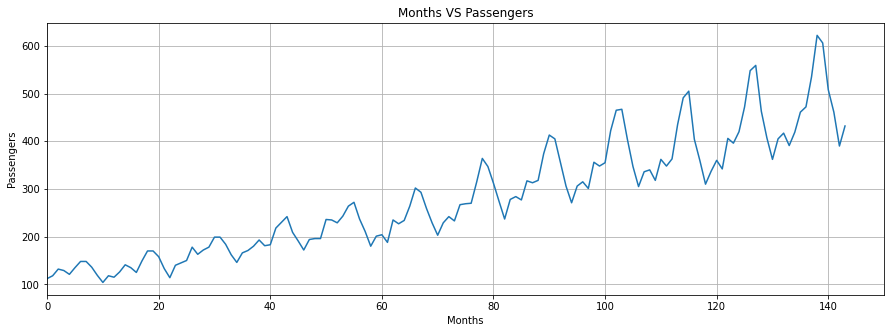

In [8]:
#Visualizing the travel data

figsize = plt.rcParams["figure.figsize"]

#set figure size to 15,5
figsize = [15,5]
plt.rcParams["figure.figsize"]= figsize

plt.title('Months VS Passengers')
plt.ylabel('Passengers')
plt.xlabel('Months')
plt.grid(True)

xmin, xmax = plt.xlim()
plt.xlim(0, 150)

plt.plot(flight_dataset['passengers'])

In [0]:
#Separate the test data (last 12 months) from the training data (first 132 Months)
#Convert the number of travellers to a floating value and assign it to a variable

app_passengers = flight_dataset['passengers'].values.astype(float)

test_data = app_passengers[132:144] 
train_data = app_passengers[:132]

In [11]:
print(app_passengers)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


In [14]:
print(len(test_data))

12


In [15]:
print(len(train_data))

132


In [23]:
#Normalize our data to a range from -1 and 1 using the minmax scaler from sklearn

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1,1))

print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


It is important to mention here that data normalization is only applied on the training data and not on the test data. If normalization is applied on the test data, there is a chance that some information will be leaked from training set into the test set.

In [24]:
train_data_normalized = torch.FloatTensor(train_data_normalized).reshape(-1)

len(train_data_normalized)

132

In [0]:
sequence_length = 12

#define a function that returns a list of sequences of 12 with a label

def create_inout_sequences(input_data,train_batch):
  inout_seq = []
  L = len(input_data)
  for i in range(L-train_batch):
    train_seq = input_data[i:train_batch+i]
    train_label = input_data[i+train_batch:i+train_batch+1]
    inout_seq.append((train_seq,train_label))
  return inout_seq

In [28]:
inout_seq=create_inout_sequences(train_data_normalized,sequence_length)

inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]), tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]), tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]), tensor([-0.9077]))]

In [29]:
len(inout_seq)

120

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer=50, output_size=1):
        super().__init__()
        self.hidden_layer = hidden_layer

        self.lstm = nn.LSTM(input_size, hidden_layer)

        self.linear = nn.Linear(hidden_layer, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer),
                            torch.zeros(1,1,self.hidden_layer))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [0]:
model = LSTM()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [69]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [70]:
epochs = 150

for i in range(epochs):
    for seq, labels in inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer),
                        torch.zeros(1, 1, model.hidden_layer))

        y_pred = model(seq)

        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.05585032
epoch:  26 loss: 0.01105365
epoch:  51 loss: 0.00074270
epoch:  76 loss: 0.00005097
epoch: 101 loss: 0.00019065
epoch: 126 loss: 0.03216401
epoch: 149 loss: 0.0001646622


In [71]:
future_prediction = 12

test_inputs = train_data_normalized[-future_prediction:].tolist()

test_inputs

[0.12527473270893097,
 0.04615384712815285,
 0.3274725377559662,
 0.2835164964199066,
 0.3890109956264496,
 0.6175824403762817,
 0.9516483545303345,
 1.0,
 0.5780220031738281,
 0.33186814188957214,
 0.13406594097614288,
 0.32307693362236023]

In [0]:
model.eval()

for i in range(future_prediction):
    seq = torch.FloatTensor(test_inputs[-12:])
    #print(seq)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer),
                        torch.zeros(1, 1, model.hidden_layer))
        test_inputs.append(model(seq).item())

In [73]:
test_inputs[12:]

[0.5010692477226257,
 0.5945185422897339,
 0.5392948389053345,
 0.7842865586280823,
 1.1586759090423584,
 0.49610182642936707,
 1.0965749025344849,
 1.2835850715637207,
 1.3087234497070312,
 1.7043095827102661,
 1.3289707899093628,
 0.8614233732223511]

In [74]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[12:] ).reshape(-1, 1))
print(actual_predictions)

[[445.49325386]
 [466.75296837]
 [454.18957585]
 [509.92519209]
 [595.09876931]
 [444.36316551]
 [580.97079033]
 [623.51560378]
 [629.23458481]
 [719.23043007]
 [633.8408547 ]
 [527.47381741]]


In [75]:
x = np.arange(132, 144, 1)
print(x)


[132 133 134 135 136 137 138 139 140 141 142 143]


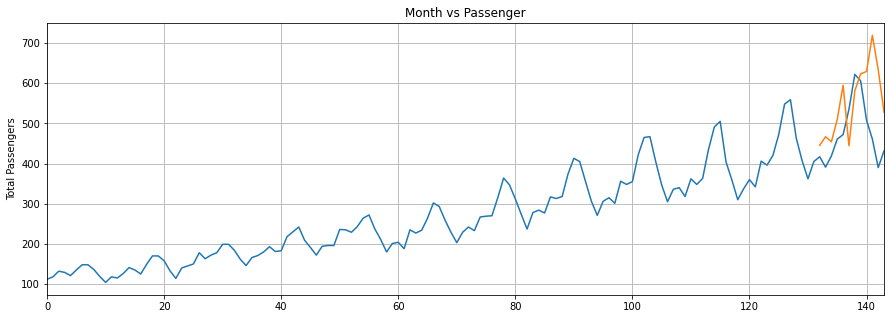

In [77]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_dataset['passengers'])
plt.plot(x,actual_predictions)
plt.show()

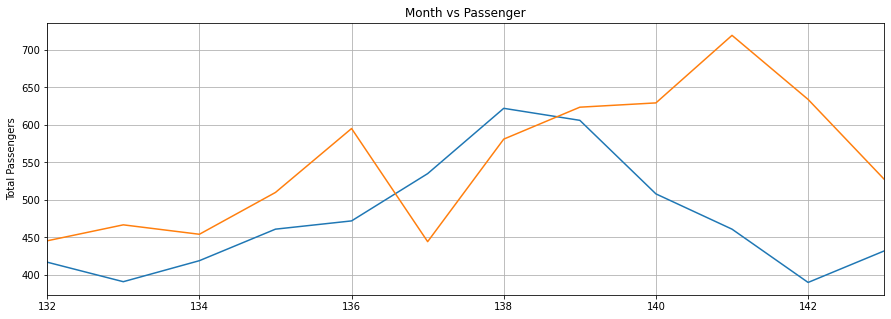

In [79]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_dataset['passengers'][-12:])
plt.plot(x,actual_predictions)
plt.show()